# 0. Utterance

In [8]:
from pathlib import Path
import logging
from io import BytesIO
import librosa
import numpy as np
import random

class Utterance(object):

    def __init__(
        self,
        _id: str = None,
        raw_file: Path | BytesIO = None,
        processor=None,
    ):
        self._id = _id
        self.raw_file = raw_file
        self.processor = processor if processor is not None else AudioPreprocessor()
#         self.audio = self.raw()

    def raw(self):
        if isinstance(self.raw_file, Path) and self.raw_file.suffix == '.npy':
            return np.load(self.raw_file)
            
        audio, _ = librosa.load(
            self.raw_file, sr=self.processor.config.SAMPLE_RATE
        )
        
        if audio.size == 0:
            raise ValueError("Empty audio")

        audio = (
            self.processor.config.SCALING_FACTOR
            * librosa.util.normalize(audio)
        )
        return audio

    def mel_in_db(self):
        try:
            return self.processor.audio_to_mel_db(self.raw())
        except Exception:

            logging.debug(
                "Failed to load Mel spectrogram, raw file: %s", {self.raw_file}
            )
            raise
    
    def random_mel_in_db(self, seq_len):
        random_mel = self.mel_in_db()
        _, tempo_len = random_mel.shape
        if tempo_len < seq_len:
            pad_left = (seq_len - tempo_len) // 2
            pad_right = seq_len - tempo_len - pad_left
            random_mel = np.pad(random_mel, ((0, 0), (pad_left, pad_right)), mode="reflect")
        elif tempo_len > seq_len:
            max_seq_start = tempo_len - seq_len
            seq_start = np.random.randint(0, max_seq_start)
            seq_end = seq_start + seq_len
            random_mel = random_mel[:, seq_start:seq_end]
        return random_mel
    
    def magtitude(self):
        return self.processor.audio_to_magnitude_db(self.raw())

# 1. Processor

## 1.1 Audio Processor

In [9]:
class AudioConfig:
    pass

In [10]:
import librosa
import numpy as np


class AudioPreprocessor:
    def __init__(self, config):
        self.config = config

    def normalize(self, spectrogram_in_db):
        '''Normalize spectrogram in decibel values between 0 and 1.'''
        normalized_spectrogram_in_db = (
            spectrogram_in_db - self.config.REF_LEVEL_DB - self.config.MIN_LEVEL_DB
        ) / -self.config.MIN_LEVEL_DB

        return np.clip(normalized_spectrogram_in_db, self.config.ZERO_THRESHOLD, 1)

    def magnitude_to_mel(self, magnitude):
        '''Convert a magnitude spectrogram to a mel spectrogram.'''
        return librosa.feature.melspectrogram(
            S=magnitude,
            sr=self.config.SAMPLE_RATE,
            n_fft=self.config.N_FFT,
            n_mels=self.config.N_MELS,
            fmin=self.config.FMIN,
            fmax=self.config.FMAX,
        )

    def amp_to_db(self, mel_spectrogram):
        '''Convert amplitude spectrogram to decibel scale.'''
        return 20.0 * np.log10(
            np.maximum(self.config.ZERO_THRESHOLD, mel_spectrogram)
        )

    def audio_to_stft(self, audio):
        '''Generate Short-Time Fourier Transform (STFT) from the audio time series.'''
        return librosa.stft(
            y=audio,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH,
            win_length=self.config.WIN_LENGTH,
        )

    def apply_pre_emphasis(self, y):
        '''Apply a pre-emphasis filter to the audio signal.'''
        return np.append(y[0], y[1:] - self.config.PRE_EMPHASIS * y[:-1])

    def stft_to_magnitude(self, linear):
        '''Compute the magnitude spectrogram from STFT.'''
        return np.abs(linear)

    def audio_to_mel_db(self, audio):
        '''Convert a given linear spectrogram to a log mel spectrogram (mel spectrogram in db) and return it.'''
        stft = self.audio_to_stft(audio)
        magnitude = self.stft_to_magnitude(stft)
        mel = self.magnitude_to_mel(magnitude)
        mel = self.amp_to_db(mel)
        return self.normalize(mel)
    
    def audio_to_magnitude_db(self, audio):
        '''Convert a given linear spectrogram to a magnitude spectrogram.'''
        stft = self.audio_to_stft(audio)
        magnitude_in_amp =  self.stft_to_magnitude(stft)
        magnitude_in_db = self.amp_to_db(magnitude_in_amp)
        return self.normalize(magnitude_in_db)

## 1.2 Text Processor

In [11]:
def sort_by_key(dictionary: dict):
    return dict(sorted(dictionary))

### 1.2.1 Acronym Normalizer

In [12]:
import json

ACRONYMS_FILEPATH = "./acronyms.json"

with open(ACRONYMS_FILEPATH, "r", encoding="utf-8") as file:
    ACRONYMS = sort_by_key(json.load(file).items())

In [13]:
import re

class AcronymNormalizer(object):

    pattern = re.compile(r"\b(" + "|".join(map(re.escape, ACRONYMS)) + r")\b")

    @classmethod
    def normalize(cls, text: str):
        def replace_unit(match):
            return ACRONYMS[match.group(0)]

        return cls.pattern.sub(replace_unit, text)


### 1.2.2 Breaker Normalizer

In [14]:
BREAKS = {
    ".": " chấm ",
    ",": " phẩy ",
}

In [15]:
import re

class BreakNormalizer(object):

    BREAKS = BREAKS

    duplicate_dot_comma_pattern = re.compile(r"([,.]){2,}")
    adjacent_symbols_pattern = re.compile(r"(\S)([,.])(\S)")
    left_symbol_pattern = re.compile(r"(\S)([,.])")
    right_symbol_pattern = re.compile(r"([,.])(\S)")

    @classmethod
    def normalize(cls, text):
        text = cls.duplicate_dot_comma_pattern.sub(lambda m: m.group(1), text)

        def replace_dot_and_comma(match):
            return match.group(1) + cls.BREAKS[match.group(2)] + match.group(3)

        text = cls.adjacent_symbols_pattern.sub(replace_dot_and_comma, text)
        text = cls.left_symbol_pattern.sub(r"\1 \2", text)
        text = cls.right_symbol_pattern.sub(r"\1 \2", text)

        return text

### 1.2.3 Character Normalizer

In [16]:
import re


class CharacterNormalizer(object):

    pattern = re.compile(r"[^a-zA-Z0-9\sđâăêôơư.,]")

    @classmethod
    def normalize(cls, text: str):

        return cls.pattern.sub("", text)


### 1.2.4 Date Normalizer

In [17]:
import json


DATE_PREFIXS_FILEPATH = "./date_prefixs.json"

with open(DATE_PREFIXS_FILEPATH, "r", encoding="utf-8") as file:
    DATE_PREFIXS = sorted(json.load(file), key=len, reverse=True)

In [18]:
import re


class DateNormalizer(object):

    DATE_PREFIXS = DATE_PREFIXS

    date_pattern1 = re.compile(r"(\b\w{0,4}\b)\s*([12][0-9]|3[01]|0?[1-9])\/(1[0-2]|0?[1-9])\/(\d{1,4})")
    date_pattern2 = re.compile(r"(\b\w{0,4}\b)\s*([12][0-9]|3[01]|0?[1-9])\-(1[0-2]|0?[1-9])\-(\d{1,4})")
    date_pattern3 = re.compile(r"(\b\w{0,5}\b)\s*(0?[1-9]|1[0,1,2])[\/|\-](\d{4})")
    prefixs = "|".join(DATE_PREFIXS)
    date_pattern4 = re.compile(r"(" + prefixs + r")\s([12][0-9]|3[01]|0?[1-9])[\-|\/](1[0-2]|0?[1-9])")

    @classmethod
    def normalize_date_pattern1(cls, text: str):
        # Date pattern 1
        # Example: 11/12/2002

        def replace(match):
            prefix = match.group(1).strip()
            day = match.group(2)
            month = match.group(3)
            year = match.group(4)

            if prefix == "ngày":
                return f"{prefix} {day} tháng {month} năm {year}"
            else:
                return f'{prefix + " " if prefix != "" else ""}ngày {day} tháng {month} năm {year}'

        return cls.date_pattern1.sub(replace, text)

    @classmethod
    def normalize_date_pattern2(cls, text: str):
        # Date pattern 1
        # Example: 11-12-2002

        def replace(match):
            prefix = match.group(1).strip()
            day = match.group(2)
            month = match.group(3)
            year = match.group(4)

            if prefix == "ngày":
                return f"{prefix} {day} tháng {month} năm {year}"
            else:
                return f'{prefix + " " if prefix != "" else ""}ngày {day} tháng {month} năm {year}'

        return cls.date_pattern2.sub(replace, text)

    @classmethod
    def normalize_date_pattern3(cls, text: str):
        # Date pattern 3
        # Example: 12/2022 -> tháng 12 năm 2002

        def replace(match):
            prefix = match.group(1)
            month = match.group(2)
            year = match.group(3)

            if prefix == "tháng":
                return f"tháng {month} năm {year}"
            else:
                return f'{prefix + " " if prefix != "" else ""}tháng {month} năm {year}'

        return cls.date_pattern3.sub(replace, text)

    @classmethod
    def normalize_date_pattern4(cls, text: str):
        # Date pattern 4
        # Example: ngày 11/12

        def replace(match):
            prefix = match.group(1)
            day = match.group(2)
            month = match.group(3)

            if prefix == "ngày":
                return f"ngày {day} tháng {month}"
            else:
                return f'{prefix + " " if prefix != "" else ""}ngày {day} tháng {month}'

        return cls.date_pattern4.sub(replace, text)

    @classmethod
    def normalize(cls, text: str):
        text = cls.normalize_date_pattern4(text)
        text = cls.normalize_date_pattern1(text)
        text = cls.normalize_date_pattern2(text)
        text = cls.normalize_date_pattern3(text)
        return text


### 1.2.5 Letter Normalizer

In [19]:
import json

LETTERS_FILEPATH = "./letters.json"

with open(LETTERS_FILEPATH, "r", encoding="utf-8") as file:
    LETTERS = sort_by_key(json.load(file).items())

In [20]:
import re

class LetterNormalizer(object):

    pattern = re.compile(r"\b(" + "|".join(map(re.escape, LETTERS)) + r")\b")

    @classmethod
    def normalize(cls, text: str):

        def replace_unit(match):
            return LETTERS[match.group(0)]

        return cls.pattern.sub(replace_unit, text)


### 1.2.6 Number Normalizer

In [21]:
import json

BASE_NUMBERS_FILEPATH = "./base_numbers.json"

with open(BASE_NUMBERS_FILEPATH, "r") as file:
    BASE_NUMBERS = {int(key): value for key, value in json.load(file).items()}

In [22]:
import json

NUMBER_LEVEL_FILEPATH = "./number_levels.json"

with open(NUMBER_LEVEL_FILEPATH, "r") as file:
    NUMBER_LEVELS = {int(key): value for key, value in json.load(file).items()}

In [23]:
import re

class NumberNomalizer(object):

    pattern = re.compile(r"\d+")

    @classmethod
    def _convert_number_2_digits(cls, number: int):
        if number in BASE_NUMBERS:
            return BASE_NUMBERS[number]

        tens = number // 10
        base = number % 10
        if base > 0:
            return f"{BASE_NUMBERS[tens]} mươi {BASE_NUMBERS[base]}"

        return f"{BASE_NUMBERS[tens]} mươi"

    @classmethod
    def _convert_number_3_digits(cls, number: int):
        if number == 0:
            return ""

        remainder = number % 100
        hundred = number // 100
        if remainder == 0:
            return f"{BASE_NUMBERS[hundred]} trăm"

        if remainder < 10:
            return f"{BASE_NUMBERS[number // 100]} trăm linh {BASE_NUMBERS[remainder]}"

        return f"{BASE_NUMBERS[hundred]} trăm {cls._convert_number_2_digits(remainder)}"

    @classmethod
    def number_to_vietnamese(cls, number: int):
        if number == 0:
            return "không"

        if number in BASE_NUMBERS:
            return BASE_NUMBERS[number]

        if number < 100:
            return cls._convert_number_2_digits(number)

        result = cls._convert_number_3_digits(number % 1000)
        current_level = None

        for current_level in NUMBER_LEVELS:
            next_level = current_level * 1000
            if number // (next_level) == 0:
                break
            level_base = number % (next_level) // current_level
            result = f"{cls._convert_number_3_digits(level_base)} {NUMBER_LEVELS[current_level]} {result}"

        level_base = number // current_level

        if level_base == 0:
            return result

        if level_base in BASE_NUMBERS:
            return f"{BASE_NUMBERS[level_base]} {NUMBER_LEVELS[current_level]} {result}"

        if level_base > 99:
            return f"{cls._convert_number_3_digits(level_base)} {NUMBER_LEVELS[current_level]} {result}"

        if level_base > 11:
            return f"{cls._convert_number_2_digits(level_base)} {NUMBER_LEVELS[current_level]} {result}"

    @classmethod
    def normalize(cls, text: str) -> str:

        replaced_text = cls.pattern.sub(lambda x: cls.number_to_vietnamese(int(x.group())), text)

        return replaced_text


### 1.2.7 Phoneme Normalizer

In [24]:
import json

SAME_PHONEMES_FILEPATH = "./same_phonemes.json"

with open(SAME_PHONEMES_FILEPATH, "r", encoding="utf-8") as file:
    SAME_PHONEMES = sort_by_key(json.load(file).items())

In [25]:
import re

class PhonemeNormalizer(object):

    pattern = re.compile(r"(" + "|".join(map(re.escape, SAME_PHONEMES)) + r")")

    @classmethod
    def normalize(cls, text: str):

        def replace_symbol(match):
            return SAME_PHONEMES[match.group(0)]

        return cls.pattern.sub(replace_symbol, text)


### 1.2.8 Symbol Normalizer

In [26]:
import json

SYMBOLS_FILEPATH = "./symbols.json"

with open(SYMBOLS_FILEPATH, "r", encoding="utf-8") as file:
    SYMBOLS = sort_by_key(json.load(file).items())

In [27]:
import re

class SymbolNormalizer(object):

    pattern = re.compile(r"([\s\S])(" + "|".join(map(re.escape, SYMBOLS)) + r")([\s\S])")

    @classmethod
    def normalize(cls, text: str):

        def replace_symbol(match):
            return (
                (match.group(1) if match.group(1) == " " else match.group(1) + " ")
                + SYMBOLS[match.group(2)]
                + (match.group(3) if match.group(3) == " " else match.group(3) + " ")
            )

        return cls.pattern.sub(replace_symbol, text)


### 1.2.9 Tone Normalizer

In [28]:
import json

TONES_FILEPATH = "./tones.json"

with open(TONES_FILEPATH, "r") as file:
    TONES = json.load(file)

In [29]:
import re

class ToneNormalizer(object):
    pattern = re.compile(r"(\w*)([áàảãạấầẩẫậắằẳẵặéèẻẽẹếềểễệíìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ])(\w*)")

    @classmethod
    def normalize(cls, text):

        def replace(match):
            accented = match.group(2)
            base, tone = TONES[accented]
            return f"{match.group(1)}{base}{match.group(3)}{tone}"

        text = cls.pattern.sub(replace, text)
        return text


### 1.2.10 Unit Normalizer

In [30]:
import json

UNITS_FILEPATH = "./units.json"

with open(UNITS_FILEPATH, "r", encoding="utf-8") as file:
    UNITS = sort_by_key(json.load(file).items())

In [31]:
import re

class UnitNormalizer(object):

    pattern = re.compile(r"\b(" + "|".join(map(re.escape, UNITS)) + r")\b")

    @classmethod
    def normalize(cls, text):

        def replace_unit(match):
            return UNITS[match.group(0)]

        return cls.pattern.sub(replace_unit, text)


### 1.2.11 Text Normalizer

In [32]:
DEFAULT_PIPELINE = [
    DateNormalizer,
    NumberNomalizer,
    LetterNormalizer,
    AcronymNormalizer,
    SymbolNormalizer,
    UnitNormalizer,
    PhonemeNormalizer,
    ToneNormalizer,
    CharacterNormalizer,
    BreakNormalizer,
]

In [33]:
class TextNormalizer(object):

    def __init__(self, pipeline=DEFAULT_PIPELINE, lower=True):
        self.pipeline = pipeline
        self.lower = lower

    def normalize(self, text):
        if self.lower:
            text = text.lower()

        for processor in self.pipeline:
            text = processor.normalize(text)

        return text

    def __call__(self, text):
        return self.normalize(text)

### 1.2.12 Text To Sequence

In [34]:
ACCENTS = ['1', '2', '3', '4', '5']

In [35]:
VOWELS_FILEPATH = "./vowels.json"

with open(VOWELS_FILEPATH, "r", encoding="utf-8") as file:
    VOWELS = sorted(json.load(file), key=len, reverse=True)

In [36]:
HEAD_CONSONANTS_FILEPATH = "./head_consonants.json"

with open(HEAD_CONSONANTS_FILEPATH, "r", encoding="utf-8") as file:
    HEAD_CONSONANTS = sorted(json.load(file), key=len, reverse=True)

In [37]:
FINAL_CONSONANTS_FILEPATH = "./final_consonants.json"
    
with open(FINAL_CONSONANTS_FILEPATH, "r", encoding="utf-8") as file:
    FINAL_CONSONANTS = sorted(json.load(file), key=len, reverse=True)


In [38]:
PHONEMES = sorted(VOWELS + HEAD_CONSONANTS + FINAL_CONSONANTS + ACCENTS + list(BREAKS.keys()), key=len, reverse=True)

In [39]:
import re

class WordByPhonemesEmbedding(object):

    def __init__(self, phonemes=PHONEMES, normalize=TextNormalizer(), spliter=" "):
        self.phonemes = phonemes
        self.normalize = normalize
        self.spliter = spliter

    def _parse_head_constants(self, word):
        pattern = r'^(' + '|'.join(HEAD_CONSONANTS) + ')'
        match = re.match(pattern, word)
        head_consonant = None
        if match:
            head_consonant = r'\b' + match.group(1)
        return re.sub(pattern, '', word), head_consonant
    
    def _parse_vowels(self, word):
        pattern = r'^(' + '|'.join(VOWELS) + ')'
        match = re.match(pattern, word)
        vowel = None
        if match:
            vowel =  match.group(1)
        return re.sub(pattern, '', word), vowel

    def _parse_final_constants(self, word):
        pattern = r'^(' + '|'.join(FINAL_CONSONANTS) + ')'
        match = re.match(pattern, word)
        final_consonant = None
        if match:
            final_consonant =  match.group(1)
        return re.sub(pattern, '', word), final_consonant

    def word2vec(self, word:str):
        embedding_vector = [0] * len(PHONEMES)
        
        word, head_consonant = self._parse_head_constants(word)
        word, vowel = self._parse_vowels(word)
        word, final_consonant = self._parse_final_constants(word)
        
        if len(word) > 0 and word[-1] in PHONEMES:
            accent_or_break = word[-1]
            embedding_vector[PHONEMES.index(accent_or_break)] = 1
            
        if head_consonant is not None:
            embedding_vector[PHONEMES.index(head_consonant)] = 1
            
        if vowel is not None:
            embedding_vector[PHONEMES.index(vowel)] = 1
            
        if final_consonant is not None:
            embedding_vector[PHONEMES.index(final_consonant)] = 1
            
        return {
            "head_consonant": head_consonant,
            "final_consonant": final_consonant,
            "vowel": vowel,
            "emmbedding_vector": embedding_vector
        }

    def embedding(self, text):
        text = self.normalize.normalize(text)
        words = text.split(self.spliter)

        return [self.word2vec(word)["emmbedding_vector"] for word in words]

    def __call__(self, text):
        return self.embedding(text)


# 2. Speech Encoder

## 2.1 Speech Encoder Audio Config

In [40]:
class SpeakerEncoderAudioConfig(AudioConfig):
    N_MELS = 80
    SAMPLE_RATE = 16000
    FRAME_SHIFT = 0.01
    FRAME_LENGTH = 0.025
    HOP_LENGTH = int(SAMPLE_RATE * FRAME_SHIFT)
    WIN_LENGTH = int(SAMPLE_RATE * FRAME_LENGTH)
    N_FFT = 1024
    FMIN = 90
    FMAX = 7600
    ZERO_THRESHOLD = 1e-5
    MIN_AMPLITUDE = 0.3
    MAX_AMPLITUDE = 1.0
    MIN_LEVEL_DB = -100
    REF_LEVEL_DB = 0
    NUM_FRAMES = 160 * 30
    SCALING_FACTOR = 0.95

## 2.2. Speech Encoder

### 2.2.1 Define Model

In [41]:
import math
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve
from torch.nn.utils import clip_grad_norm_
from scipy.optimize import brentq
import torch
import torch.nn as nn
import numpy as np

class SpeechTransformerEncoder(nn.Module):
    def __init__(self, input_size=80, hidden_size=786, num_layers=12, num_heads=8, device='cpu', loss_device='cpu'):
        super().__init__()
        self.device = device
        self.loss_device = loss_device
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,
            dropout=0.05,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)

        self.linear = nn.Linear(in_features=input_size, out_features=256).to(device)
        self.relu = nn.ReLU().to(device)

        # Cosine similarity scaling (with fixed initial parameter values)
        self.similarity_weight = nn.Parameter(torch.tensor([10.])).to(loss_device)
        self.similarity_bias = nn.Parameter(torch.tensor([-5.])).to(loss_device)

        # Loss
        self.loss_fn = nn.CrossEntropyLoss().to(loss_device)

    def do_gradient_ops(self):
        # Gradient scale
        self.similarity_weight.grad *= 0.01
        self.similarity_bias.grad *= 0.01

        # Gradient clipping
        clip_grad_norm_(self.parameters(), 3, norm_type=2)

    def forward(self, utterances, hidden_init=None):
        """
        Computes the embeddings of a batch of utterance spectrograms.

        :param utterances: batch of mel-scale filterbanks of same duration as a tensor of shape
        (batch_size, n_frames, n_channels)
        :param hidden_init: not used in the Transformer version
        :return: the embeddings as a tensor of shape (batch_size, embedding_size)
        """
        utterances = utterances.to(self.device)
        # Pass the input through the Transformer Encoder
        out = self.transformer_encoder(utterances)

        # We take the mean of all time steps (similar to a global pooling)
        embeds_raw = self.relu(self.linear(out.mean(dim=1)))

        # L2-normalize it
        embeds = embeds_raw / torch.norm(embeds_raw, dim=1, keepdim=True)

        return embeds

    def similarity_matrix(self, embeds):
        """
        Computes the similarity matrix according of GE2E.

        :param embeds: the embeddings as a tensor of shape (speakers_per_batch,
        utterances_per_speaker, embedding_size)
        :return: the similarity matrix as a tensor of shape (speakers_per_batch,
        utterances_per_speaker, speakers_per_batch)
        """
        speakers_per_batch, utterances_per_speaker = embeds.shape[:2]

        # Inclusive centroids (1 per speaker). Cloning is needed for reverse differentiation
        centroids_incl = torch.mean(embeds, dim=1, keepdim=True)
        centroids_incl = centroids_incl.clone() / torch.norm(centroids_incl, dim=2, keepdim=True)

        # Exclusive centroids (1 per utterance)
        centroids_excl = (torch.sum(embeds, dim=1, keepdim=True) - embeds)
        centroids_excl /= (utterances_per_speaker - 1)
        centroids_excl = centroids_excl.clone() / torch.norm(centroids_excl, dim=2, keepdim=True)

        # Similarity matrix computation
        sim_matrix = torch.zeros(speakers_per_batch, utterances_per_speaker,
                                 speakers_per_batch).to(self.loss_device)
        mask_matrix = 1 - np.eye(speakers_per_batch, dtype=np.int64)
        for j in range(speakers_per_batch):
            mask = np.where(mask_matrix[j])[0]
            sim_matrix[mask, :, j] = (embeds[mask] * centroids_incl[j]).sum(dim=2)
            sim_matrix[j, :, j] = (embeds[j] * centroids_excl[j]).sum(dim=1)

        sim_matrix = sim_matrix * self.similarity_weight + self.similarity_bias
        return sim_matrix

    def loss(self, embeds):
        """
        Computes the softmax loss according the section 2.1 of GE2E.

        :param embeds: the embeddings as a tensor of shape (speakers_per_batch,
        utterances_per_speaker, embedding_size)
        :return: the loss and the EER for this batch of embeddings.
        """
        speakers_per_batch, utterances_per_speaker = embeds.shape[:2]

        # Loss
        sim_matrix = self.similarity_matrix(embeds)
        sim_matrix = sim_matrix.reshape((speakers_per_batch * utterances_per_speaker,
                                         speakers_per_batch))
        ground_truth = np.repeat(np.arange(speakers_per_batch), utterances_per_speaker)
        target = torch.from_numpy(ground_truth).long().to(self.loss_device)
        loss = self.loss_fn(sim_matrix, target)

        # EER (not backpropagated)
        with torch.no_grad():
            inv_argmax = lambda i: np.eye(1, speakers_per_batch, i, dtype=np.int64)[0]
            labels = np.array([inv_argmax(i) for i in ground_truth])
            preds = sim_matrix.detach().cpu().numpy()

            # Snippet from https://yangcha.github.io/EER-ROC/
            fpr, tpr, thresholds = roc_curve(labels.flatten(), preds.flatten())
            eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

        return loss, eer


### 2.2.2 Speech Encoder Model Config

In [42]:
!ls

000000036000.pt				  same_phonemes.json
FPTOpenSpeechData_Set001_V0.1_000004.mp3  saved_models
acronyms.json				  saved_models_12
actual_magnitude.png			  saved_nonmasked_models
actual_mel.png				  symbols.json
base_numbers.json			  t2s-model1.ipynb
checkpoint_postnet_54000.pt		  t2s-model1.py
date_prefixs.json			  t2s-model2.ipynb
encoded_speechs				  t2s-test.ipynb
final_consonants.json			  t2s.py
gen_encoded_speech.ipynb		  tones.json
head_consonants.json			  training_loss.png
letters.json				  transcripts.json
mag2mel_training_loss.png		  units.json
mags					  vietnamese-normalize-text-bank.zip
mels					  vlsp-2020-fods.zip
number_levels.json			  vlsp2020-fosd-mag-mel-transcript.zip
predicted_mel.png			  vowels.json
predicted_post_mel.png


In [43]:
class SpeechrTransformerEncoderModelConfigs:
    DEVICE = "cuda:0"
    LOSS_DEVICE = "cpu"
    MODEL_PATH = "./000000036000.pt"

### 2.2.3 Load Speech Encoder Model

In [44]:
import torch
import torch.nn as nn

def load_speaker_transformer_encoder(model_settings):
    model = SpeechTransformerEncoder(
        device="cpu", loss_device=model_settings.LOSS_DEVICE
    )
    ckpt = torch.load(model_settings.MODEL_PATH, weights_only=False,
                      map_location="cpu")

    if ckpt:
        model.load_state_dict(ckpt["model_state_dict"], strict=False)

    model.eval()
    model.to("cpu")
    return model

In [45]:
SPEECH_TRANSFORMER_ENCODER = load_speaker_transformer_encoder(
    SpeechrTransformerEncoderModelConfigs
)
# SPEECH_TRANSFORMER_ENCODER = None

# 3. Text to Speech

## 3.1 Text to Speech Audio Config

In [46]:
class Text2SpeechAudioConfig:
    N_MELS = 80
    SAMPLE_RATE = 16000
    N_FFT = 2048
    FRAME_SHIFT = 0.0125
    FRAME_LENGTH = 0.05
    REF_LEVEL_DB = 20
    HOP_LENGTH = int(SAMPLE_RATE * FRAME_SHIFT)
    WIN_LENGTH = int(SAMPLE_RATE * FRAME_LENGTH)
    PRE_EMPHASIS = 0.97
    POWER = 1.2
    FMIN = 90
    FMAX = 7600
    ZERO_THRESHOLD = 1e-5
    MIN_LEVEL_DB = -100

## 3.2 Text to Speech Model

### 3.2.1 Positional Encoding

In [47]:
import numpy as np
import torch

def get_sinusoid_encoding_table(n_position, num_hidden, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / num_hidden)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(num_hidden)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)

### 3.2.2 Model

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def get_sinusoid_encoding_table(n_position, num_hidden, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / num_hidden)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(num_hidden)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)


class ScaledPositionalEncoding(nn.Module):
    def __init__(self, d_model, n_position=2048, dropout=0.1, padding_idx=None):
        super(ScaledPositionalEncoding, self).__init__()
        
        self.alpha = nn.Parameter(torch.ones(1))  # Scaling factor
        
        # Get sinusoid encoding table
        self.positional_embedding = nn.Embedding.from_pretrained(
            get_sinusoid_encoding_table(n_position, d_model, padding_idx=padding_idx),
            freeze=True
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, pos):
        pos = self.positional_embedding(pos)
        x = pos * self.alpha + x
        return self.dropout(x)
        

class TextEncoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, embedding_size=91,max_position_encoding=4096*2, dropout=0.1):
        super(TextEncoder, self).__init__()
        # Encoder Prenet
        self.encoder_prenet = nn.Linear(embedding_size, d_model)
        
        # Scaled Positional Encoding
        self.positional_encoding = ScaledPositionalEncoding(d_model, n_position=max_position_encoding, dropout=dropout, padding_idx=0)
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout, dim_feedforward=d_model, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        
    def forward(self, text, pos_text, src_mask=None, src_key_padding_mask=None):
        text = self.encoder_prenet(text)
        
        # Positional encoding
        text = self.positional_encoding(text, pos_text)

        # Pass through transformer encoder
        encoded_text = self.transformer_encoder(text, src_key_padding_mask=src_key_padding_mask)
        
        return encoded_text


class Projection(nn.Module):
    def __init__(self, d_model):
        super(Projection, self).__init__()
        self.fc = nn.Linear(d_model * 2, d_model)  # Concatenates Text + Audio encodings

    def forward(self, encoded_speech, memory):
        # Ensure both tensors are on the same device
#         encoded_speech = encoded_speech.to("cuda:0")
        duplicated_encoded_speech = encoded_speech.repeat(1, memory.shape[1], 1)
#         memory = memory.to("cuda:0")

        # Concatenate along the feature dimension
        concat_enc = torch.cat((duplicated_encoded_speech, memory), dim=-1)

        # Pass through fully connected layer
        return self.fc(concat_enc)


class PostConvNet(nn.Module):
    """
    Post Convolutional Network (mel --> mel)
    """
    def __init__(self, num_hidden, num_mels=80, outputs_per_step=1, dropout_prob=0.1):
        """
        :param num_hidden: Dimension of hidden layers.
        :param num_mels: Number of mel bands.
        :param outputs_per_step: Number of outputs per step.
        :param dropout_prob: Probability for dropout layers.
        """
        super(PostConvNet, self).__init__()
        
        # Define input and output channel dimensions
        self.num_mels = num_mels
        self.outputs_per_step = outputs_per_step
        self.num_hidden = num_hidden
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(
            in_channels=num_mels * outputs_per_step,
            out_channels=num_hidden,
            kernel_size=5,
            padding=4
        )
        
        # Three repeated convolutional layers with batch normalization
        self.conv_list = nn.ModuleList([
            nn.Conv1d(
                in_channels=num_hidden,
                out_channels=num_hidden,
                kernel_size=5,
                padding=4
            )
            for _ in range(3)
        ])
        self.batch_norm_list = nn.ModuleList([nn.BatchNorm1d(num_hidden) for _ in range(3)])
        
        # Final convolutional layer
        self.conv2 = nn.Conv1d(
            in_channels=num_hidden,
            out_channels=num_mels * outputs_per_step,
            kernel_size=5,
            padding=4
        )
        
        # Batch normalization for the first convolution
        self.pre_batchnorm = nn.BatchNorm1d(num_hidden)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout_list = nn.ModuleList([nn.Dropout(p=dropout_prob) for _ in range(3)])

    def forward(self, x, mask=None):
        """
        Forward pass of the PostConvNet.
        
        :param x: Input tensor (batch_size, num_mels * outputs_per_step, seq_len).
        :param mask: Mask (optional, not used in this implementation).
        :return: Output tensor (batch_size, num_mels * outputs_per_step, seq_len).
        """
        # Apply the first convolution, batch normalization, activation, and dropout
        x = self.conv1(x)
        x = self.pre_batchnorm(x)
        x = torch.tanh(x)
        x = self.dropout1(x[:, :, :-4])  # Slice to simulate causal behavior
        
        # Apply repeated convolutions with batch norm, activation, and dropout
        for conv, batch_norm, dropout in zip(self.conv_list, self.batch_norm_list, self.dropout_list):
            x = conv(x)
            x = batch_norm(x)
            x = torch.tanh(x)
            x = dropout(x[:, :, :-4])  # Slice to simulate causal behavior
        
        # Apply the final convolution and slicing
        x = self.conv2(x)[:, :, :-4]
        return x


class MelDecoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, mel_dim, max_position_encoding=8192, dropout=0.1, padding_idx=0):
        super(MelDecoder, self).__init__()
        
        # Decoder prenet: 3 linear layers with xavier uniform initialization
        self.prenet = nn.Linear(mel_dim, d_model)
        
        # Scaled Positional Encoding
        self.positional_encoding = ScaledPositionalEncoding(d_model, n_position=max_position_encoding, dropout=dropout)
        
        # Transformer Decoder Layers
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout, dim_feedforward=d_model)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output layer for mel spectrogram prediction
        self.mel_linear = nn.Linear(d_model, mel_dim)
        
        self.postconvnet = PostConvNet(d_model)


    def forward(self, memory, input_mel, pos_mel, memory_mask=None, memory_key_padding_mask=None, tgt_mask=None, tgt_key_padding_mask=None):
        
        # Prenet processing on mel spectrogram input
        mel_embeds = self.prenet(input_mel)
        
        # Positional encoding for mel spectrogram
        mel_embeds = self.positional_encoding(mel_embeds, pos_mel)
        
        # Reshape for TransformerDecoder (sequence length first)
        mel_embeds_reshaped = mel_embeds.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        memory_reshaped = memory.permute(1, 0, 2)          # [seq_len, batch_size, d_model]
        

        # Transformer decoder: Multi-head attention and feed-forward layers
        decoded_output = self.transformer_decoder(
            tgt=mel_embeds_reshaped, 
            memory=memory_reshaped,
            memory_mask=memory_mask,
            tgt_mask=tgt_mask,                      # Attention mask for target sequence
            memory_key_padding_mask=memory_key_padding_mask,  # Key padding mask for memory (encoder outputs)
            tgt_key_padding_mask=tgt_key_padding_mask,        # Key padding mask for target (mel spectrograms)
#             tgt_is_causal=True,
#             memory_is_causal=True
        )
        
        decoded_output = decoded_output.permute(1, 0, 2)  # Reshape back to [batch_size, seq_len, d_model]
        
        # Linear layer to predict mel spectrogram
        mel_output = self.mel_linear(decoded_output)
        postnet_ouput = self.postconvnet(mel_output.permute(0, 2, 1))
        postnet_ouput = postnet_ouput.permute(0, 2, 1)
        return mel_output, postnet_ouput


class TNTModel(nn.Module):
    def __init__(self, d_model=256, num_heads=8):
        super(TNTModel, self).__init__()
        self.encoder = TextEncoder(d_model=d_model, num_heads=num_heads, num_layers=3)
        self.projection = Projection(d_model)
        self.decoder = MelDecoder(d_model=d_model, num_heads=num_heads, num_layers=3, mel_dim=80)
        
    def forward(self, text, pos_text, input_mel, pos_mel, encoded_speech):
        batch_size = text.size(0)
        decoder_len = input_mel.size(1)
        input_len = text.size(1)
        
        if self.training:
            # Create a triangular mask for the target sequence
#             tgt_mask = torch.triu(
#                 torch.full((decoder_len, decoder_len), float("-inf"), dtype=torch.float32, device=input_mel.device), diagonal=1
#             )
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_len, device=input_mel.device)
            # memory_mask = self._generate_subsequent_mask(decoder_len, input_len).to(input_mel.device)
            memory_mask = None
            tgt_key_padding_mask = pos_mel.eq(0)
            src_key_padding_mask = memory_key_padding_mask = pos_text.eq(0)
            src_mask = None
        else:
            memory_mask = None
            tgt_mask = torch.triu(
                torch.full((decoder_len, decoder_len), float("-inf"), dtype=torch.float32, device=input_mel.device), diagonal=1
            )
            # memory_mask = self._generate_subsequent_mask(decoder_len, input_len).to(input_mel.device)
            src_mask, tgt_key_padding_mask, src_key_padding_mask, memory_key_padding_mask = None, None, None, None
        
        memory = self.encoder(text, pos_text, src_mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        memory = self.projection(encoded_speech, memory)
        mel_output, postnet_ouput = self.decoder(memory, input_mel, pos_mel, memory_mask=memory_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return mel_output, postnet_ouput
    
    def _generate_subsequent_mask(self, tgt_sz, src_sz):
        mask = (torch.triu(torch.ones(src_sz, tgt_sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# 4. Dataset

## 4.1 Dataset Model

In [50]:
import numpy as np
from pathlib import Path

def load_mel(file_path: Path):
    """
    Load a Mel spectrogram saved as a .npy file.

    :param file_path: Path to the .npy file containing the Mel spectrogram
    :return: Numpy array of the Mel spectrogram
    """
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
    try:
        mel_spectrogram = np.load(file_path)
    except EOFError:
        print(f"File could not be loaded due to EOFError: {random_file}")
        return False
    return mel_spectrogram


In [51]:
import json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset
import os

class TTSDataset(Dataset):
    
    def __init__(self, root: Path=None, text_map: dict=None, text_map_file: Path=None, tokenizer=None):
        """
        :param root: Path to the audio files directory
        :param text_map: A dictionary mapping audio file names to their corresponding texts
        :param text_map_file: Path to the JSON file containing the text map
        :param tokenizer: A custom tokenizer for text processing
        """
        self.root = root
        self.text_map = text_map if text_map is not None else self.load_text_map(text_map_file)
        self.audios = os.listdir("./encoded_speechs")
        self.texts = self.text_map
        self.tokenizer = tokenizer if tokenizer is not None else self.default_tokenizer
        self.encoded_speech_dir = Path("./encoded_speechs")
        self.mel_dir = Path("./mels")

        
    def load_text_map(self, text_map_file: Path):
        with text_map_file.open('r') as file:
            text_map = json.load(file)
        return text_map
    
    def __len__(self):
        return len(self.audios)

    def _get_audio_input(self, speech_output):
        """
        Method to get input audio for the decoder, used for inference, like teacher-forcing mode
        """
        speech_input = np.concatenate([np.zeros([1, Text2SpeechAudioConfig.N_MELS], np.float32), 
                                       speech_output[:-1, :]], axis=0)
        return speech_input

    def _get_audio_output(self, idx):
        """
        Get ground truth audio (target output), loading from .npy file if it exists.
        """
        mel_file = self.mel_dir / f"{self.audios[idx]}.npy"
        
        if mel_file.exists():
            return load_mel(mel_file).T
        else:
            print(f"not found: {mel_file}")
            utterance = Utterance(
                raw_file=self.root / f"{self.audios[idx]}.npy",
                processor=AudioPreprocessor(Text2SpeechAudioConfig)
            )
            return utterance.mel_in_db().T
    
    def default_tokenizer(self, text):
        """
        Default tokenizer method if no custom tokenizer is provided.
        Tokenizes text to a sequence of integers or phonemes.
        """
        # Example: basic character tokenizer, can be replaced with more complex tokenizers
        return [ord(char) for char in text]
    
    def _get_encoded_speech(self, idx):
        """
        Get encoded speech randomly from a folder.
        """
        audio_name = self.audios[idx]  # Extract the audio name without extension
        encoded_speech_subfolder = self.encoded_speech_dir / audio_name  # Path to subfolder
        encoded_speech_files = list(encoded_speech_subfolder.glob("*.npy"))  # List of all `.pt` files
        
        if not encoded_speech_files:
            utterance = Utterance(raw_file=self.root / self.audios[idx], 
                              processor=AudioPreprocessor(SpeakerEncoderAudioConfig))
        
            random_mel = torch.tensor(np.array([utterance.random_mel_in_db(4800)])).transpose(1, 2)
            
            with torch.no_grad():
                encoded_speech = SPEECH_TRANSFORMER_ENCODER(random_mel)
                
            return encoded_speech
        
        random_file = random.choice(encoded_speech_files)  # Select a random `.pt` file
        try:
            encoded_speech = np.load(random_file)
        except EOFError:
            utterance = Utterance(raw_file=self.root / self.audios[idx], 
                              processor=AudioPreprocessor(SpeakerEncoderAudioConfig))
        
            random_mel = torch.tensor(np.array([utterance.random_mel_in_db(4800)])).transpose(1, 2)
            
            with torch.no_grad():
                encoded_speech = SPEECH_TRANSFORMER_ENCODER(random_mel)
                
            return encoded_speech.cpu().numpy()
        
        return encoded_speech
    
    def __getitem__(self, idx):
        """
        Get text sequence, input audio (for teacher-forcing), and output audio (ground truth)
        """
        # Text to sequence using custom tokenizer
        text_sequence = self.tokenizer(self.texts[self.audios[idx]])

        # Get Encoding Speech
        encoded_speech = self._get_encoded_speech(idx)

        # Get the audio output (target output)
        output_audio = self._get_audio_output(idx)
        
        # Get the audio input (decoder input)
        input_audio = self._get_audio_input(output_audio)
        
        # Get positional text
        text_length = len(text_sequence)
        pos_text = np.arange(1, text_length + 1)
        
        # Get positional mel
        pos_audio = np.arange(1, input_audio.shape[0] + 1)
        
        return {
            "text": np.array(text_sequence),
            "text_length": len(text_sequence),
            "input_mel": input_audio,
            "encoded_speech": encoded_speech,
            "mel": output_audio,
            "pos_text": pos_text,
            "pos_mel": pos_audio
        }

In [52]:
len(os.listdir("./encoded_speechs"))

56427

## 4.2 Load Dataset

In [53]:
from pathlib import Path

DATA_PATH = Path(r"./mags")
TEXT_MAP_PATH = Path(r"./transcripts.json")

In [54]:
dataset = TTSDataset(root=DATA_PATH, text_map_file=TEXT_MAP_PATH, tokenizer=WordByPhonemesEmbedding())

In [55]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

## 4.3 Collate

In [56]:
import torch

def _pad_data(x, length):
    _pad = 0
    return np.pad(x, (0, length - x.shape[0]), mode='constant', constant_values=_pad)



def _prepare_data(inputs):
    max_len = max((len(x) for x in inputs))
    return np.stack([_pad_data(x, max_len) for x in inputs])


def _pad_2d(inputs):
    _pad = 0
    def _pad_one(x, max_len):
        mel_len = x.shape[0]
        return np.pad(x, [[0,max_len - mel_len],[0,0]], mode='constant', constant_values=_pad)
    max_len = max((x.shape[0] for x in inputs))
    return np.stack([_pad_one(x, max_len) for x in inputs])


def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x['text_length'], reverse=True)
    
    text = [d['text'] for d in batch]
    mel = [d['mel'] for d in batch]
    mel_input = [d['input_mel'] for d in batch]
    pos_text = [d['pos_text'] for d in batch]
    pos_mel = [d['pos_mel'] for d in batch]
    encoded_speech= [d['encoded_speech'] for d in batch]

    text = torch.FloatTensor(_pad_2d(text))
    mel = torch.FloatTensor(_pad_2d(mel))
    mel_input = torch.FloatTensor(_pad_2d(mel_input))
    pos_text = torch.LongTensor(_prepare_data(pos_text))
    pos_mel = torch.LongTensor(_prepare_data(pos_mel))
    encoded_speech = torch.FloatTensor(np.array(encoded_speech))


    return text, mel, mel_input, encoded_speech, pos_text, pos_mel

## 4.4 DataLoader

In [57]:
from torch.utils.data import DataLoader

# Create the DataLoader with the custom collate function
eval_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

# 5. Trainning 

In [58]:
EPOCHS = 10000
LEARNING_RATE = 1e-4

In [59]:
def save_checkpoint(
    model, optimizer, epoch, global_step, train_losses, eval_losses, save_path, current_subset=0
):
    checkpoint = {
        "epoch": epoch,
        "global_step": global_step,
        "current_subset": current_subset,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "eval_losses": eval_losses,
    }
    model_path = f"{save_path}/model_epoch_{epoch}_subset_{current_subset}.pt"
    torch.save(checkpoint, f"{model_path}")
    print(f"Checkpoint saved at {model_path}")


In [60]:
import os
def load_checkpoint(save_path, model, optimizer, device):
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        global_step = checkpoint["global_step"]
        current_subset = checkpoint["current_subset"]
        train_losses = checkpoint["train_losses"]
        eval_losses = checkpoint["eval_losses"]
        print(f"Checkpoint loaded from {save_path}")
        return model, optimizer, epoch, global_step, current_subset, train_losses, eval_losses
    else:
        print(f"No checkpoint found at {save_path}, starting fresh.")
        return model, optimizer, 0, 0, 0, [], []


In [61]:
torch.cuda.device_count()

4

In [62]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB


In [106]:
from torch import optim

EPOCHS = 10000
LEARNING_RATE = 1e-4
# Default Model, Optimizer and params
device = "cuda:0"
model = nn.DataParallel(TNTModel().to(device))
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
global_step = 0
current_subset = 0
start_epoch = 0
train_losses = []
eval_losses = []
save_path = "./saved_models"

In [107]:
model_save_path ='./saved_nonmasked_models/model_epoch_89_subset_0.pt'
# model_save_path ='./saved_models/model_epoch_243_subset_0.pt'
model, optimizer, start_epoch, global_step, current_subset, train_losses, eval_losses = load_checkpoint(
    save_path=model_save_path, model=model, optimizer=optimizer, device=device
)
# if current_subset == 3:
#     current_subset = 0
#     start_epoch += 1
# else:
#     current_subset += 1

Checkpoint loaded from ./saved_nonmasked_models/model_epoch_89_subset_0.pt


/tmp/ipykernel_1703979/3047576538.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


In [ ]:
losses = [
    0.0506,
    0.0293,
    0.041,
    0.0258,
    0.0296,
    0.0263,
    0.0248,
    0.0276,
    0.028,
    0.0249,
    0.0232,
    0.0291,
    0.0249,
    0.0196,
    0.0259,
    0.0221,
    0.0195,
    0.0357,
    0.0232,
    0.0294,
    0.0266,
    0.0201,
    0.0181,
    0.0252,
    0.0196,
    0.0329,
    0.0211,
    0.0233,
    0.0157,
    0.0181
]

In [65]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel('Step (each 2000)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./mag2mel_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'losses' is not defined

In [ ]:
dataset[0]["mel"].shape, dataset[1]["mel"].shape, dataset[2]["mel"].shape

In [ ]:
train_losses[-1]

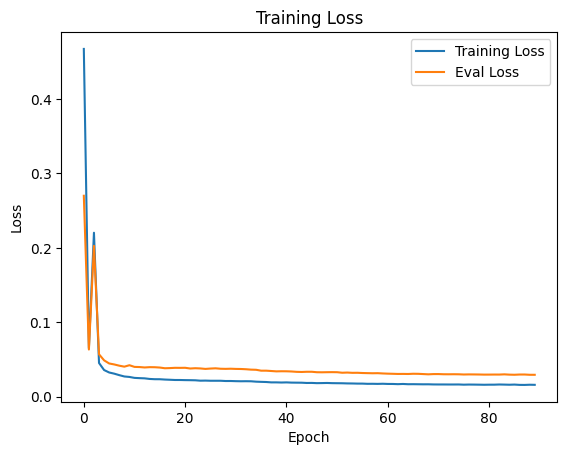

In [77]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./training_eval_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
torch.cuda.is_available()

True

In [69]:
dataset.texts["FPTOpenSpeechData_Set001_V0.1_000004"]

'có rất nhiều yếu tố may rủi ở đây'

In [70]:
T2S_GEN = AudioPreprocessor(Text2SpeechAudioConfig)

(80, 277)


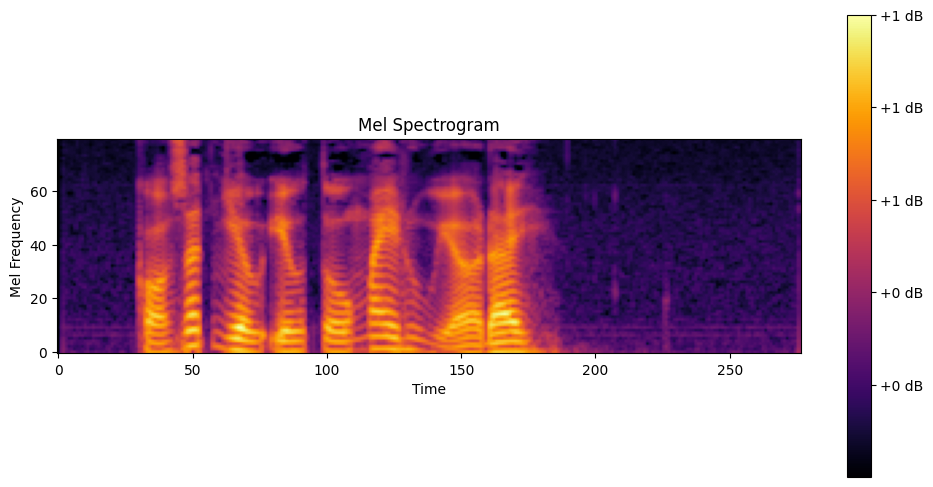

In [71]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio, sr = librosa.load('./FPTOpenSpeechData_Set001_V0.1_000004.mp3', sr=16000)

actual_mel = T2S_GEN.audio_to_mel_db(audio)
print(actual_mel.shape)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(actual_mel, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig('./actual_mel.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
def preprocess_audio(file: BytesIO | str | Path) -> torch.Tensor:
    uttn = Utterance(
        raw_file=file, processor=AudioPreprocessor(config=SpeakerEncoderAudioConfig)
    )

    return torch.tensor(
        np.array(
            [uttn.random_mel_in_db(seq_len=160)]
        )
    ).transpose(1, 2)

def get_encoded_speech(audio, speaker_verification_model):
    processed_audio = preprocess_audio(audio)
    with torch.no_grad():
        encoded_speech = speaker_verification_model(processed_audio)
    return encoded_speech

In [73]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def compare_mel_spectrograms(mel1, mel2):

    # Plot the two log-mel spectrograms side-by-side
    plt.figure(figsize=(12, 6))

    # First spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mel1, sr=16000, hop_length=Text2SpeechAudioConfig.HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log-Mel Spectrogram 1")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency (Hz)")

    # Second spectrogram
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mel2, sr=16000, hop_length=Text2SpeechAudioConfig.HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log-Mel Spectrogram 2")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency (Hz)")

    plt.tight_layout()
    plt.show()

In [90]:
from tqdm import tqdm

def generate_speech(text_to_speech_model, text, audio, speaker_verification_model):
    text_to_speech_model.eval()
    t2seq = WordByPhonemesEmbedding()

    text_sequence = torch.FloatTensor(np.array([t2seq(text)])).to("cuda:0")

    text_length = len(text_sequence) 
    encoded_speech = get_encoded_speech(speaker_verification_model=speaker_verification_model, audio=audio).to("cuda:0")
    mel_input = torch.FloatTensor(np.array([np.zeros([1, Text2SpeechAudioConfig.N_MELS], np.float32)])).to("cuda:0")
                                      
    pos_text = torch.LongTensor(np.array([np.arange(1, text_length + 1)])).to("cuda:0")
    pbar = tqdm(range(400))

    with torch.no_grad():
        for i in pbar:
            pos_audio = torch.arange(1, mel_input.size(1) + 1).unsqueeze(0).cuda()
            mel_pred, postnet_ouput = text_to_speech_model(text_sequence, pos_text, mel_input, pos_audio, encoded_speech)
            mel_input = torch.concat([mel_input, mel_pred[:, -1:, :]], dim=1)
    
    mel = postnet_ouput.detach().cpu().numpy()[0].T
    compare_mel_spectrograms(mel_input.detach().cpu().numpy()[0], postnet_ouput.detach().cpu().numpy()[0])
    amplitude_mel = librosa.db_to_amplitude(mel)

    # Convert mel to linear spectrogram
    linear_spectrogram = librosa.feature.inverse.mel_to_stft(
        amplitude_mel,
        sr=Text2SpeechAudioConfig.SAMPLE_RATE,
        n_fft=Text2SpeechAudioConfig.N_FFT
    )
    print(f"Linear spectrogram shape: {linear_spectrogram.shape}")

    # Reconstruct audio using Griffin-Lim
    audio = librosa.griffinlim(
        linear_spectrogram,
        hop_length=Text2SpeechAudioConfig.HOP_LENGTH,
        win_length=Text2SpeechAudioConfig.WIN_LENGTH,
        n_iter=32
    )
    print(f"Reconstructed audio length: {len(audio)} samples")
    return audio, mel_input.detach().cpu().numpy()[0].T, postnet_ouput.detach().cpu().numpy()[0].T

In [91]:
import torch
torch.cuda.empty_cache()

100%|██████████| 400/400 [00:07<00:00, 55.10it/s]


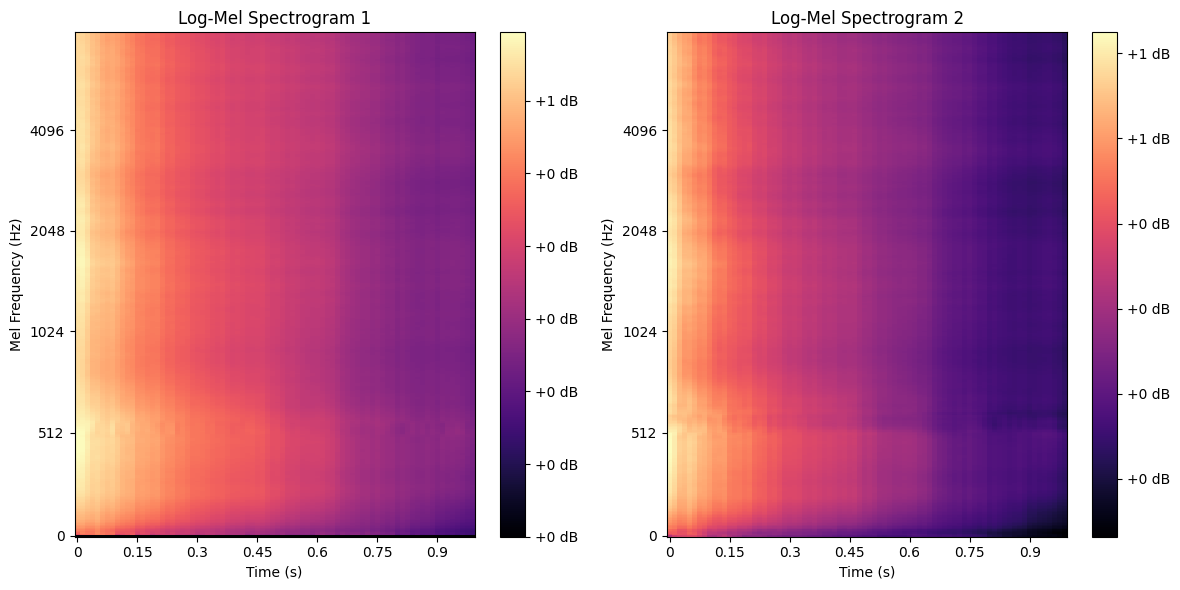

Linear spectrogram shape: (1025, 400)
Reconstructed audio length: 79800 samples


In [101]:
audio, mel, post_mel = generate_speech(model, text="có rất nhiều yếu tố may rủi ở đây", audio="./FPTOpenSpeechData_Set001_V0.1_000004.mp3", speaker_verification_model=SPEECH_TRANSFORMER_ENCODER)


100%|██████████| 400/400 [00:04<00:00, 81.01it/s]


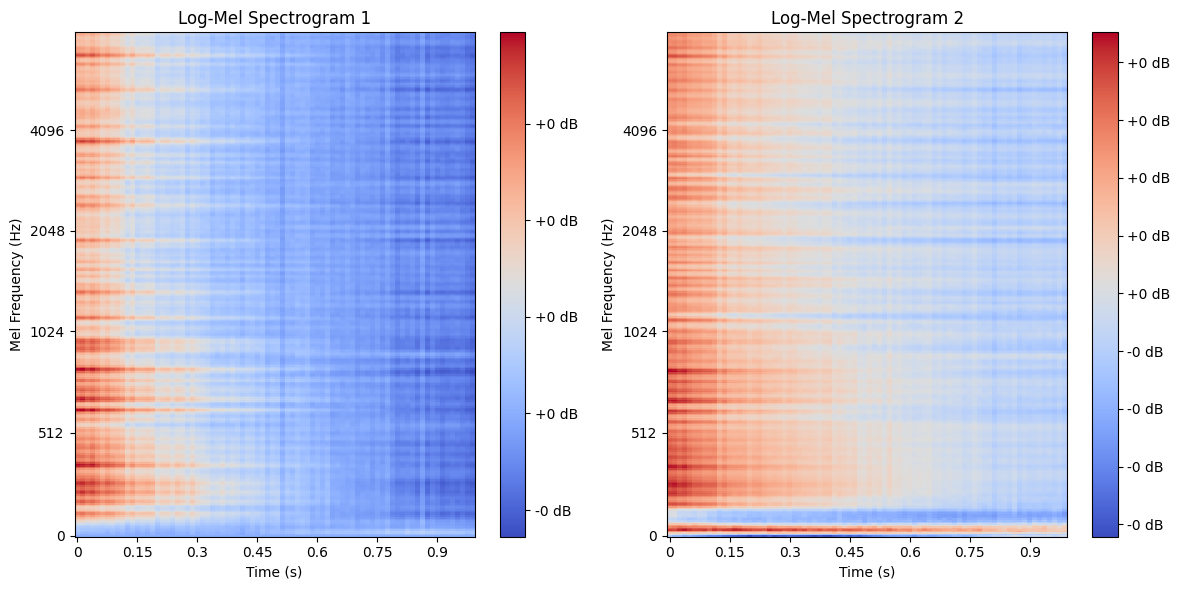

Linear spectrogram shape: (1025, 400)
Reconstructed audio length: 79800 samples


In [108]:
audio, mel, post_mel = generate_speech(model, text="có rất nhiều yếu tố may rủi ở đây", audio="./FPTOpenSpeechData_Set001_V0.1_000004.mp3", speaker_verification_model=SPEECH_TRANSFORMER_ENCODER)


In [102]:
mel.shape

(80, 401)

(80, 400)


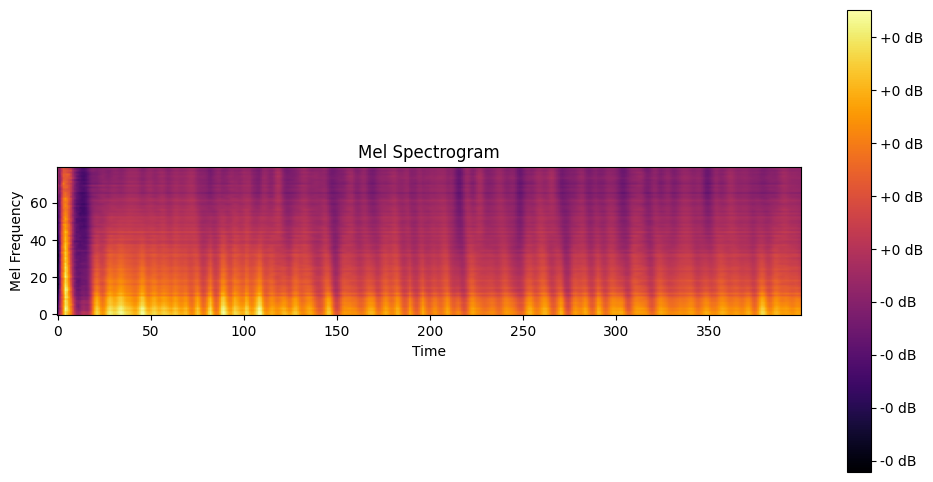

In [109]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

print(post_mel.shape)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(post_mel, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig('./predicted_post_mel.png', dpi=300, bbox_inches='tight')
plt.show()

(80, 401)


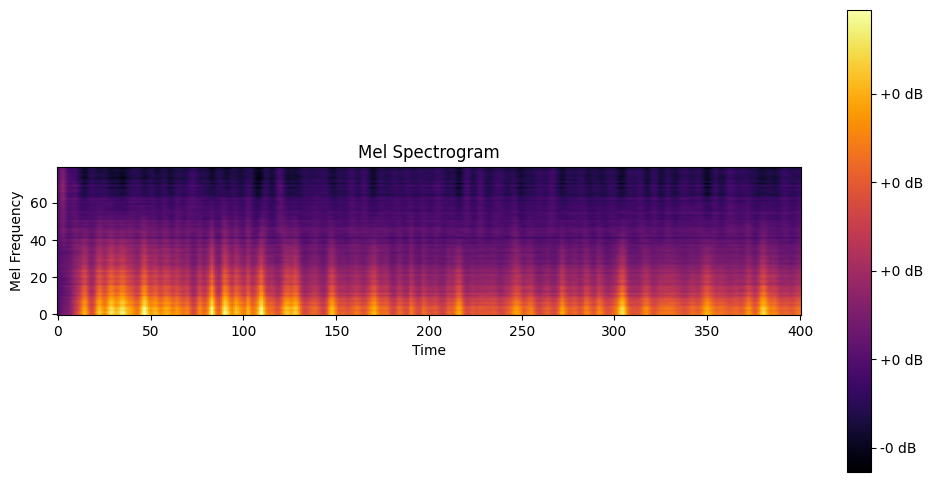

In [110]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

print(mel.shape)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(mel, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig('./predicted_mel.png', dpi=300, bbox_inches='tight')
plt.show()

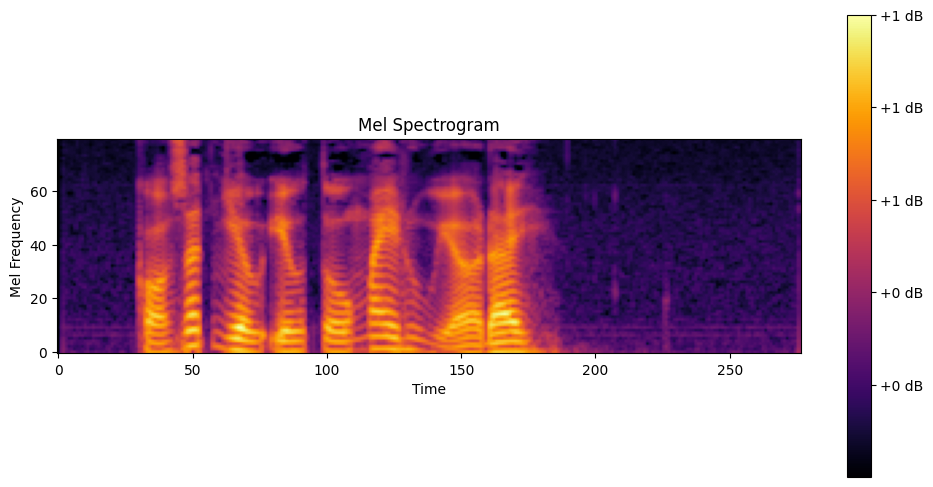

In [89]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio, sr = librosa.load('./FPTOpenSpeechData_Set001_V0.1_000004.mp3', sr=16000)

actual_mel = T2S_GEN.audio_to_mel_db(audio)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(actual_mel, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()



In [92]:
np.max(actual_mel)

np.float32(1.0)

In [ ]:
np.max(actual_mel)

In [94]:
np.max(post_mel)

np.float32(0.54363304)

In [ ]:
import torch.nn as nn
import torch as t
import torch.nn.functional as F
import math
import numpy as np
import copy
from collections import OrderedDict

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Linear(nn.Module):
    """
    Linear Module
    """
    def __init__(self, in_dim, out_dim, bias=True, w_init='linear'):
        """
        :param in_dim: dimension of input
        :param out_dim: dimension of output
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Linear, self).__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim, bias=bias)

        nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        return self.linear_layer(x)


class Conv(nn.Module):
    """
    Convolution Module
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=0, dilation=1, bias=True, w_init='linear'):
        """
        :param in_channels: dimension of input
        :param out_channels: dimension of output
        :param kernel_size: size of kernel
        :param stride: size of stride
        :param padding: size of padding
        :param dilation: dilation rate
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Conv, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation,
                              bias=bias)

        nn.init.xavier_uniform_(
            self.conv.weight, gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        x = self.conv(x)
        return x

class CBHG(nn.Module):
    """
    CBHG Module
    """
    def __init__(self, hidden_size, K=16, projection_size = 256, num_gru_layers=2, max_pool_kernel_size=2, is_post=False):
        """
        :param hidden_size: dimension of hidden unit
        :param K: # of convolution banks
        :param projection_size: dimension of projection unit
        :param num_gru_layers: # of layers of GRUcell
        :param max_pool_kernel_size: max pooling kernel size
        :param is_post: whether post processing or not
        """
        super(CBHG, self).__init__()
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        self.convbank_list = nn.ModuleList()
        self.convbank_list.append(nn.Conv1d(in_channels=projection_size,
                                                out_channels=hidden_size,
                                                kernel_size=1,
                                                padding=int(np.floor(1/2))))

        for i in range(2, K+1):
            self.convbank_list.append(nn.Conv1d(in_channels=hidden_size,
                                                out_channels=hidden_size,
                                                kernel_size=i,
                                                padding=int(np.floor(i/2))))

        self.batchnorm_list = nn.ModuleList()
        for i in range(1, K+1):
            self.batchnorm_list.append(nn.BatchNorm1d(hidden_size))

        convbank_outdim = hidden_size * K
        
        self.conv_projection_1 = nn.Conv1d(in_channels=convbank_outdim,
                                             out_channels=hidden_size,
                                             kernel_size=3,
                                             padding=int(np.floor(3 / 2)))
        self.conv_projection_2 = nn.Conv1d(in_channels=hidden_size,
                                               out_channels=projection_size,
                                               kernel_size=3,
                                               padding=int(np.floor(3 / 2)))
        self.batchnorm_proj_1 = nn.BatchNorm1d(hidden_size)

        self.batchnorm_proj_2 = nn.BatchNorm1d(projection_size)


        self.max_pool = nn.MaxPool1d(max_pool_kernel_size, stride=1, padding=1)
        self.highway = Highwaynet(self.projection_size)
        self.gru = nn.GRU(self.projection_size, self.hidden_size // 2, num_layers=num_gru_layers,
                          batch_first=True,
                          bidirectional=True)


    def _conv_fit_dim(self, x, kernel_size=3):
        if kernel_size % 2 == 0:
            return x[:,:,:-1]
        else:
            return x

    def forward(self, input_):

        input_ = input_.contiguous()
        batch_size = input_.size(0)
        total_length = input_.size(-1)

        convbank_list = list()
        convbank_input = input_

        # Convolution bank filters
        for k, (conv, batchnorm) in enumerate(zip(self.convbank_list, self.batchnorm_list)):
            convbank_input = t.relu(batchnorm(self._conv_fit_dim(conv(convbank_input), k+1).contiguous()))
            convbank_list.append(convbank_input)

        # Concatenate all features
        conv_cat = t.cat(convbank_list, dim=1)

        # Max pooling
        conv_cat = self.max_pool(conv_cat)[:,:,:-1]

        # Projection
        conv_projection = t.relu(self.batchnorm_proj_1(self._conv_fit_dim(self.conv_projection_1(conv_cat))))
        conv_projection = self.batchnorm_proj_2(self._conv_fit_dim(self.conv_projection_2(conv_projection))) + input_

        # Highway networks
        highway = self.highway.forward(conv_projection.transpose(1,2))
        

        # Bidirectional GRU
        
        self.gru.flatten_parameters()
        out, _ = self.gru(highway)

        return out


class Highwaynet(nn.Module):
    """
    Highway network
    """
    def __init__(self, num_units, num_layers=4):
        """
        :param num_units: dimension of hidden unit
        :param num_layers: # of highway layers
        """
        super(Highwaynet, self).__init__()
        self.num_units = num_units
        self.num_layers = num_layers
        self.gates = nn.ModuleList()
        self.linears = nn.ModuleList()
        for _ in range(self.num_layers):
            self.linears.append(Linear(num_units, num_units))
            self.gates.append(Linear(num_units, num_units))

    def forward(self, input_):

        out = input_

        # highway gated function
        for fc1, fc2 in zip(self.linears, self.gates):

            h = t.relu(fc1.forward(out))
            t_ = t.sigmoid(fc2.forward(out))

            c = 1. - t_
            out = h * t_ + out * c

        return out

class ModelPostNet(nn.Module):
    """
    CBHG Network (mel --> linear)
    """
    def __init__(self):
        super(ModelPostNet, self).__init__()
        self.pre_projection = Conv(80, 256)  # replaced hp.n_mels with 80 and hp.hidden_size with 256
        self.cbhg = CBHG(256)  # replaced hidden_size with 256
        self.post_projection = Conv(256, (2048 // 2) + 1)  # replaced hp.n_fft with 2024 and hp.hidden_size with 256

    def forward(self, mel):
        mel = mel.transpose(1, 2)
        mel = self.pre_projection(mel)
        mel = self.cbhg(mel).transpose(1, 2)
        mag_pred = self.post_projection(mel).transpose(1, 2)

        return mag_pred

In [ ]:
global_step = 0

# Initialize the model and move to GPU
model = nn.DataParallel(ModelPostNet().cuda())
epochs = 10000
lr = 0.001
save_step = 2000
batch_size = 64
checkpoint_folder = '/kaggle/working/'
criterion = nn.L1Loss()  # Loss function

checkpoint = torch.load(r"checkpoint_postnet_54000.pt", map_location=torch.device('cuda'), weights_only=False)
model.load_state_dict(checkpoint["model"])
model.train()

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio, sr = librosa.load('./FPTOpenSpeechData_Set001_V0.1_000004.mp3', sr=16000)

actual_mag = T2S_GEN.audio_to_magnitude_db(audio)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(actual_mag, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Magnitude Frequency')
plt.title('Magnitude Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig('./actual_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()